# Import packages and modules

In [39]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import lifelines
import patsy
from sklearn import linear_model, metrics, model_selection

# plot style
sns.set(style = "darkgrid", context = "notebook", palette = "colorblind", font_scale = 1.5)

# Data

## Presidential Cabinet Nominations
Downloaded from [Kaggle - Presidential Cabinet Nominations: Senate confirmation vote records for cabinet nominees since 1976](https://www.kaggle.com/senate/confirmation-votes) and modified with [Donald J. Trump Cabinet Nominations](https://www.senate.gov/legislative/nominations/Trump_cabinet.htm)

In [2]:
presidential_cabinet_nominations = pd.read_csv("presidential_cabinet_nominations.csv")

# sample it
presidential_cabinet_nominations.sample(n = 10, replace = False)

,position,president,nominee,announced_date,received_date,withdrawn_date,confirmed_date,rejected_date,vote_type,votes_for,votes_against
106,Secretary of the Treasury,Bill Clinton,Lawrence Summers,1999-05-12,1999-06-07,NaN,1999-07-01,NaN,Roll Call Vote,97.0,2.0
168,Secretary of the Interior,Barack Obama,Sally Jewell,2013-02-06,2013-02-07,NaN,2013-04-10,NaN,Roll Call Vote,87.0,11.0
125,Secretary of Housing & Urban Development,George W. Bush,Alphonso Jackson,2003-12-12,2004-01-28,NaN,2004-03-31,NaN,Voice Vote,NaN,NaN
185,Secretary of Commerce,Donald J. Trump,Wilbur Ross,2016-11-30,2017-01-20,NaN,2017-02-27,NaN,NaN,72.0,27.0
17,Secretary of Transportation,Jimmy Carter,Neil Goldschmidt,1979-07-27,1979-09-10,NaN,1979-09-21,NaN,Roll Call Vote,83.0,0.0
68,Secretary of Energy,George H.W. Bush,James Watkins,1989-01-12,1989-01-20,NaN,1989-03-01,NaN,Roll Call Vote,99.0,0.0
202,Secretary of Veterans Affairs,Donald J. Trump,Robert Wilkie,2018-05-18,2018-06-20,NaN,2018-07-23,NaN,NaN,86.0,9.0
24,Secretary of Health & Human Services,Ronald Reagan,Richard Schweiker,1980-12-11,1981-01-20,NaN,1981-01-21,NaN,Roll Call Vote,99.0,0.0
50,Secretary of Labor,Ronald Reagan,Ann McLaughlin,1987-11-03,1987-12-01,NaN,1987-12-11,NaN,Roll Call Vote,94.0,0.0
102,Secretary of Labor,Bill Clinton,Alexis Herman,1996-12-20,1997-01-07,NaN,1997-04-30,NaN,Roll Call Vote,85.0,13.0


In [3]:
presidential_cabinet_nominations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   position        211 non-null    object 
 1   president       211 non-null    object 
 2   nominee         211 non-null    object 
 3   announced_date  211 non-null    object 
 4   received_date   200 non-null    object 
 5   withdrawn_date  11 non-null     object 
 6   confirmed_date  190 non-null    object 
 7   rejected_date   1 non-null      object 
 8   vote_type       166 non-null    object 
 9   votes_for       141 non-null    float64
 10  votes_against   141 non-null    float64
dtypes: float64(2), object(9)
memory usage: 18.3+ KB


## Biden Cabinet Nominations

In [4]:
biden_cabinet_nominations = pd.read_csv("biden_cabinet_nominations.csv")

# to date time
biden_cabinet_nominations["announced_datetime"] = pd.to_datetime(biden_cabinet_nominations["announced_date"])

biden_cabinet_nominations["announced_year"] = biden_cabinet_nominations["announced_datetime"].dt.year

biden_cabinet_nominations

,position,president,nominee,announced_date,announced_datetime,announced_year
0,Secretary of Homeland Security,Joseph R. Biden,Alejandro Mayorkas,2020-11-23,2020-11-23,2020
1,Secretary of State,Joseph R. Biden,Antony Blinken,2020-11-24,2020-11-24,2020
2,Secretary of the Interior,Joseph R. Biden,Deb Haaland,2020-12-17,2020-12-17,2020
3,Secretary of Veterans Affairs,Joseph R. Biden,Denis McDonough,2020-12-10,2020-12-10,2020
4,Secretary of Defense,Joseph R. Biden,Gen. Lloyd Austin,2020-12-07,2020-12-07,2020
5,Secretary of Commerce,Joseph R. Biden,Gina Raimondo,2021-01-07,2021-01-07,2021
6,Secretary of the Treasury,Joseph R. Biden,Janet Yellen,2020-11-30,2020-11-30,2020
7,Secretary of Energy,Joseph R. Biden,Jennifer Granholm,2020-12-17,2020-12-17,2020
8,Secretary of Housing & Urban Development,Joseph R. Biden,Marcia Fudge,2020-12-10,2020-12-10,2020
9,Secretary of Labor,Joseph R. Biden,Marty Walsh,2021-01-07,2021-01-07,2021


## Modify dates

In [5]:
# date times
presidential_cabinet_nominations["announced_datetime"] = pd.to_datetime(presidential_cabinet_nominations["announced_date"])

presidential_cabinet_nominations["received_datetime"] = pd.to_datetime(presidential_cabinet_nominations["received_date"])

presidential_cabinet_nominations["withdrawn_datetime"] = pd.to_datetime(presidential_cabinet_nominations["withdrawn_date"])

presidential_cabinet_nominations["confirmed_datetime"] = pd.to_datetime(presidential_cabinet_nominations["confirmed_date"])

presidential_cabinet_nominations["announced_year"] = presidential_cabinet_nominations["announced_datetime"].dt.year

presidential_cabinet_nominations["confirmed_year"] = presidential_cabinet_nominations["confirmed_datetime"].dt.year

In [6]:
presidential_cabinet_nominations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   position            211 non-null    object        
 1   president           211 non-null    object        
 2   nominee             211 non-null    object        
 3   announced_date      211 non-null    object        
 4   received_date       200 non-null    object        
 5   withdrawn_date      11 non-null     object        
 6   confirmed_date      190 non-null    object        
 7   rejected_date       1 non-null      object        
 8   vote_type           166 non-null    object        
 9   votes_for           141 non-null    float64       
 10  votes_against       141 non-null    float64       
 11  announced_datetime  211 non-null    datetime64[ns]
 12  received_datetime   200 non-null    datetime64[ns]
 13  withdrawn_datetime  11 non-null     datetime64[ns]

## Life times

In [7]:
presidential_cabinet_nominations["announced_confirmed_days"] = (presidential_cabinet_nominations["confirmed_datetime"] - presidential_cabinet_nominations["announced_datetime"]).dt.days

presidential_cabinet_nominations["received_confirmed_days"] = (presidential_cabinet_nominations["confirmed_datetime"] - presidential_cabinet_nominations["received_datetime"]).dt.days

## Vote variables

In [8]:
presidential_cabinet_nominations["n_votes"] = presidential_cabinet_nominations["votes_for"] + presidential_cabinet_nominations["votes_against"]

presidential_cabinet_nominations["votes_for_ppt"] = presidential_cabinet_nominations["votes_for"] / presidential_cabinet_nominations["n_votes"]

# sample it
presidential_cabinet_nominations.sample(n = 10, replace = False)

,position,president,nominee,announced_date,received_date,withdrawn_date,confirmed_date,rejected_date,vote_type,votes_for,...,announced_datetime,received_datetime,withdrawn_datetime,confirmed_datetime,announced_year,confirmed_year,announced_confirmed_days,received_confirmed_days,n_votes,votes_for_ppt
66,Secretary of Veterans Affairs,George H.W. Bush,Edward Derwinski,1988-12-22,1989-01-20,NaN,1989-03-02,NaN,Roll Call Vote,94.0,...,1988-12-22,1989-01-20,NaT,1989-03-02,1988,1989.0,70.0,41.0,94.0,1.000000
56,Secretary of the Treasury,George H.W. Bush,Nicholas Brady,1988-11-15,NaN,NaN,NaN,NaN,NaN,NaN,...,1988-11-15,NaT,NaT,NaT,1988,NaN,NaN,NaN,NaN,NaN
15,Secretary of Energy,Jimmy Carter,"Charles Duncan, Jr.",1979-07-20,1979-07-21,NaN,1979-07-31,NaN,Roll Call Vote,95.0,...,1979-07-20,1979-07-21,NaT,1979-07-31,1979,1979.0,11.0,10.0,96.0,0.989583
64,Secretary of the Interior,George H.W. Bush,"Manuel Lujan, Jr.",1988-12-22,1989-01-20,NaN,1989-02-02,NaN,Roll Call Vote,100.0,...,1988-12-22,1989-01-20,NaT,1989-02-02,1988,1989.0,42.0,13.0,100.0,1.000000
163,Secretary of Defense,Barack Obama,Leon Panetta,2011-04-28,2011-05-26,NaN,2011-06-21,NaN,Roll Call Vote,100.0,...,2011-04-28,2011-05-26,NaT,2011-06-21,2011,2011.0,54.0,26.0,100.0,1.000000
26,Secretary of Transportation,Ronald Reagan,"Andrew Lewis, Jr.",1980-12-11,1981-01-20,NaN,1981-01-22,NaN,Roll Call Vote,98.0,...,1980-12-11,1981-01-20,NaT,1981-01-22,1980,1981.0,42.0,2.0,98.0,1.000000
23,Secretary of Defense,Ronald Reagan,Caspar Weinberger,1980-12-11,1981-01-20,NaN,1981-01-20,NaN,Roll Call Vote,97.0,...,1980-12-11,1981-01-20,NaT,1981-01-20,1980,1981.0,40.0,0.0,99.0,0.979798
44,Secretary of the Interior,Ronald Reagan,Donald Hodel,1985-01-10,1985-01-23,NaN,1985-02-06,NaN,Roll Call Vote,93.0,...,1985-01-10,1985-01-23,NaT,1985-02-06,1985,1985.0,27.0,14.0,94.0,0.989362
126,Attorney General,George W. Bush,Alberto Gonzales,2004-11-10,2004-11-16,NaN,NaN,NaN,NaN,NaN,...,2004-11-10,2004-11-16,NaT,NaT,2004,NaN,NaN,NaN,NaN,NaN
67,Secretary of Labor,George H.W. Bush,Elizabeth Dole,1988-12-24,1989-01-20,NaN,1989-01-25,NaN,Roll Call Vote,99.0,...,1988-12-24,1989-01-20,NaT,1989-01-25,1988,1989.0,32.0,5.0,99.0,1.000000


## Flag whether nominee is first nominee for president

In [9]:
presidential_cabinet_nominations["first_pick"] = (presidential_cabinet_nominations["announced_datetime"] == presidential_cabinet_nominations.groupby(["president", "position"])["announced_datetime"].transform(min)).astype(float).replace({0: -0.5, 1: 0.5})

## Subset only announcement and confirmation

In [10]:
nominee_announced_confirmed = presidential_cabinet_nominations.loc[:, ["position", "president", "nominee", "first_pick", "announced_datetime", "confirmed_datetime", "announced_year", "confirmed_year", "announced_confirmed_days", "votes_for", "votes_against", "n_votes", "votes_for_ppt"]].dropna().drop_duplicates()

nominee_announced_confirmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 4 to 210
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   position                  138 non-null    object        
 1   president                 138 non-null    object        
 2   nominee                   138 non-null    object        
 3   first_pick                138 non-null    float64       
 4   announced_datetime        138 non-null    datetime64[ns]
 5   confirmed_datetime        138 non-null    datetime64[ns]
 6   announced_year            138 non-null    int64         
 7   confirmed_year            138 non-null    float64       
 8   announced_confirmed_days  138 non-null    float64       
 9   votes_for                 138 non-null    float64       
 10  votes_against             138 non-null    float64       
 11  n_votes                   138 non-null    float64       
 12  votes_for_ppt         

# Descriptives

In [43]:
nominee_announced_confirmed["announced_confirmed_days"].describe()

count    138.000000
mean      50.985507
std       38.635294
min        7.000000
25%       32.000000
50%       42.000000
75%       62.000000
max      397.000000
Name: announced_confirmed_days, dtype: float64

In [11]:
nominee_announced_confirmed.groupby("position")["announced_confirmed_days"].describe().sort_values("50%")

,count,mean,std,min,25%,50%,75%,max
position,,,,,,,,
Secretary of Education,7.0,36.285714,19.250232,15.0,29.00,31.0,37.00,76.0
Secretary of Veterans Affairs,6.0,43.000000,19.707866,25.0,30.00,34.0,58.25,70.0
Secretary of the Interior,9.0,44.555556,18.682285,27.0,31.00,36.0,63.00,76.0
Secretary of Energy,10.0,46.100000,24.043710,11.0,31.50,39.0,66.75,82.0
Secretary of Defense,11.0,36.181818,19.717090,7.0,21.50,40.0,49.00,69.0
Secretary of Agriculture,7.0,54.000000,28.501462,28.0,33.00,41.0,74.00,95.0
Secretary of Transportation,11.0,42.545455,14.313376,22.0,29.00,42.0,54.50,63.0
Secretary of Housing & Urban Development,8.0,45.750000,17.766341,31.0,34.75,42.5,47.00,87.0
Secretary of the Treasury,10.0,43.900000,18.174769,14.0,36.25,44.5,51.50,75.0


# Plots

## Secretary of Housing & Urban Development Announced-Confirm lifetime

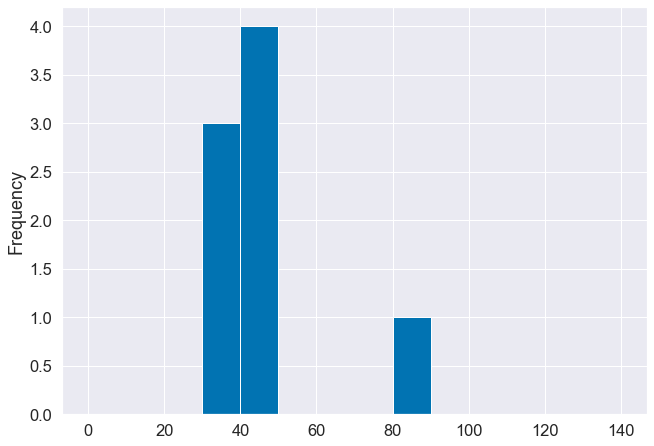

In [12]:
nominee_announced_confirmed.query("position == 'Secretary of Housing & Urban Development'")["announced_confirmed_days"].plot(kind = "hist", bins = np.arange(0, 150, 10), edgecolor = "white", figsize = (10.5, 7.5));

## Secretary of Housing & Urban Development Announced-Confirm lifetime over time

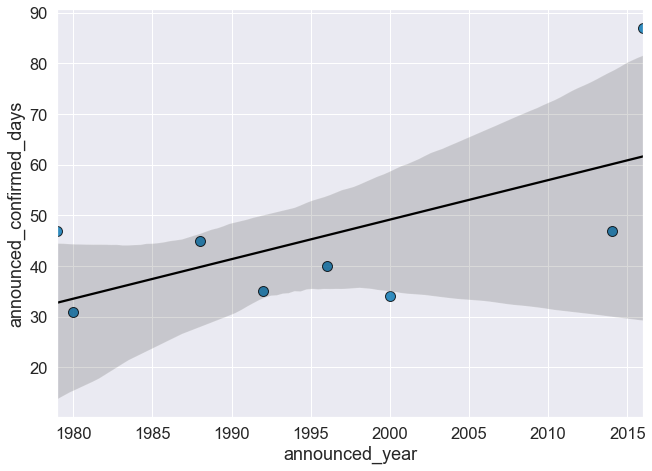

In [13]:
fig, axes = plt.subplots(figsize = (10.5, 7.5))

sns.regplot(x = "announced_year", y = "announced_confirmed_days", data = nominee_announced_confirmed.query("position == 'Secretary of Housing & Urban Development'"), scatter_kws = {"s": 100, "edgecolor": "black"}, lowess = False, line_kws = {"color": "black"}, ax = axes)

## All secretaries announced-confirmed days by year

## Secretary of of the Interior Announced-Confirm lifetime over time

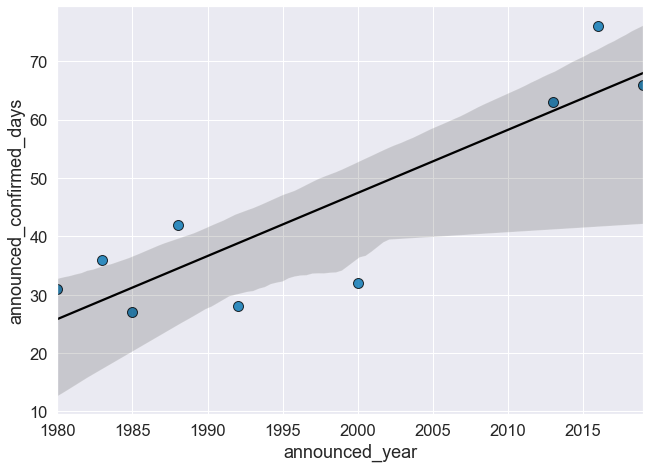

In [14]:
fig, axes = plt.subplots(figsize = (10.5, 7.5))

sns.regplot(x = "announced_year", y = "announced_confirmed_days", data = nominee_announced_confirmed.query("position == 'Secretary of the Interior'"), scatter_kws = {"s": 100, "edgecolor": "black"}, lowess = False, line_kws = {"color": "black"}, ax = axes);

## Secretary of Labor Announced-Confirm lifetime over time

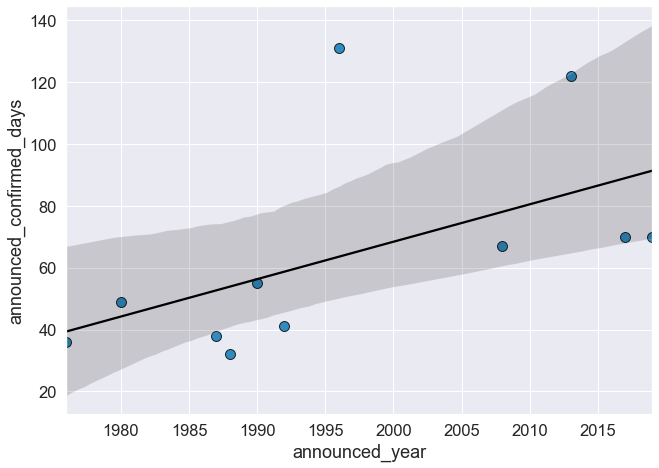

In [15]:
fig, axes = plt.subplots(figsize = (10.5, 7.5))

sns.regplot(x = "announced_year", y = "announced_confirmed_days", data = nominee_announced_confirmed.query("position == 'Secretary of Labor'"), scatter_kws = {"s": 100, "edgecolor": "black"}, lowess = False, line_kws = {"color": "black"}, ax = axes);

## Attorney General Announced-Confirm lifetime over time

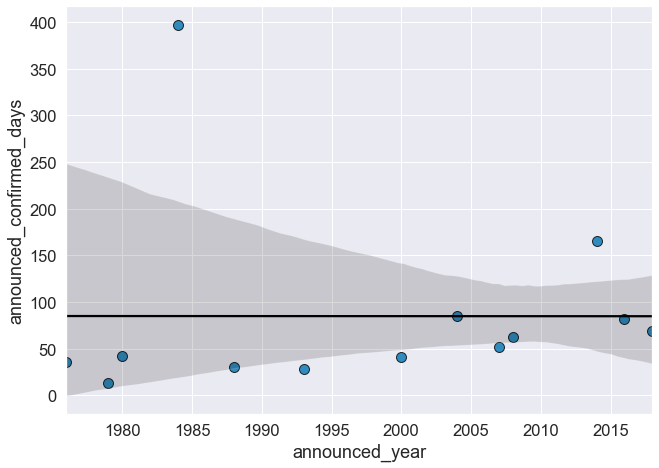

In [16]:
fig, axes = plt.subplots(figsize = (10.5, 7.5))

sns.regplot(x = "announced_year", y = "announced_confirmed_days", data = nominee_announced_confirmed.query("position == 'Attorney General'"), scatter_kws = {"s": 100, "edgecolor": "black"}, lowess = False, line_kws = {"color": "black"}, ax = axes);

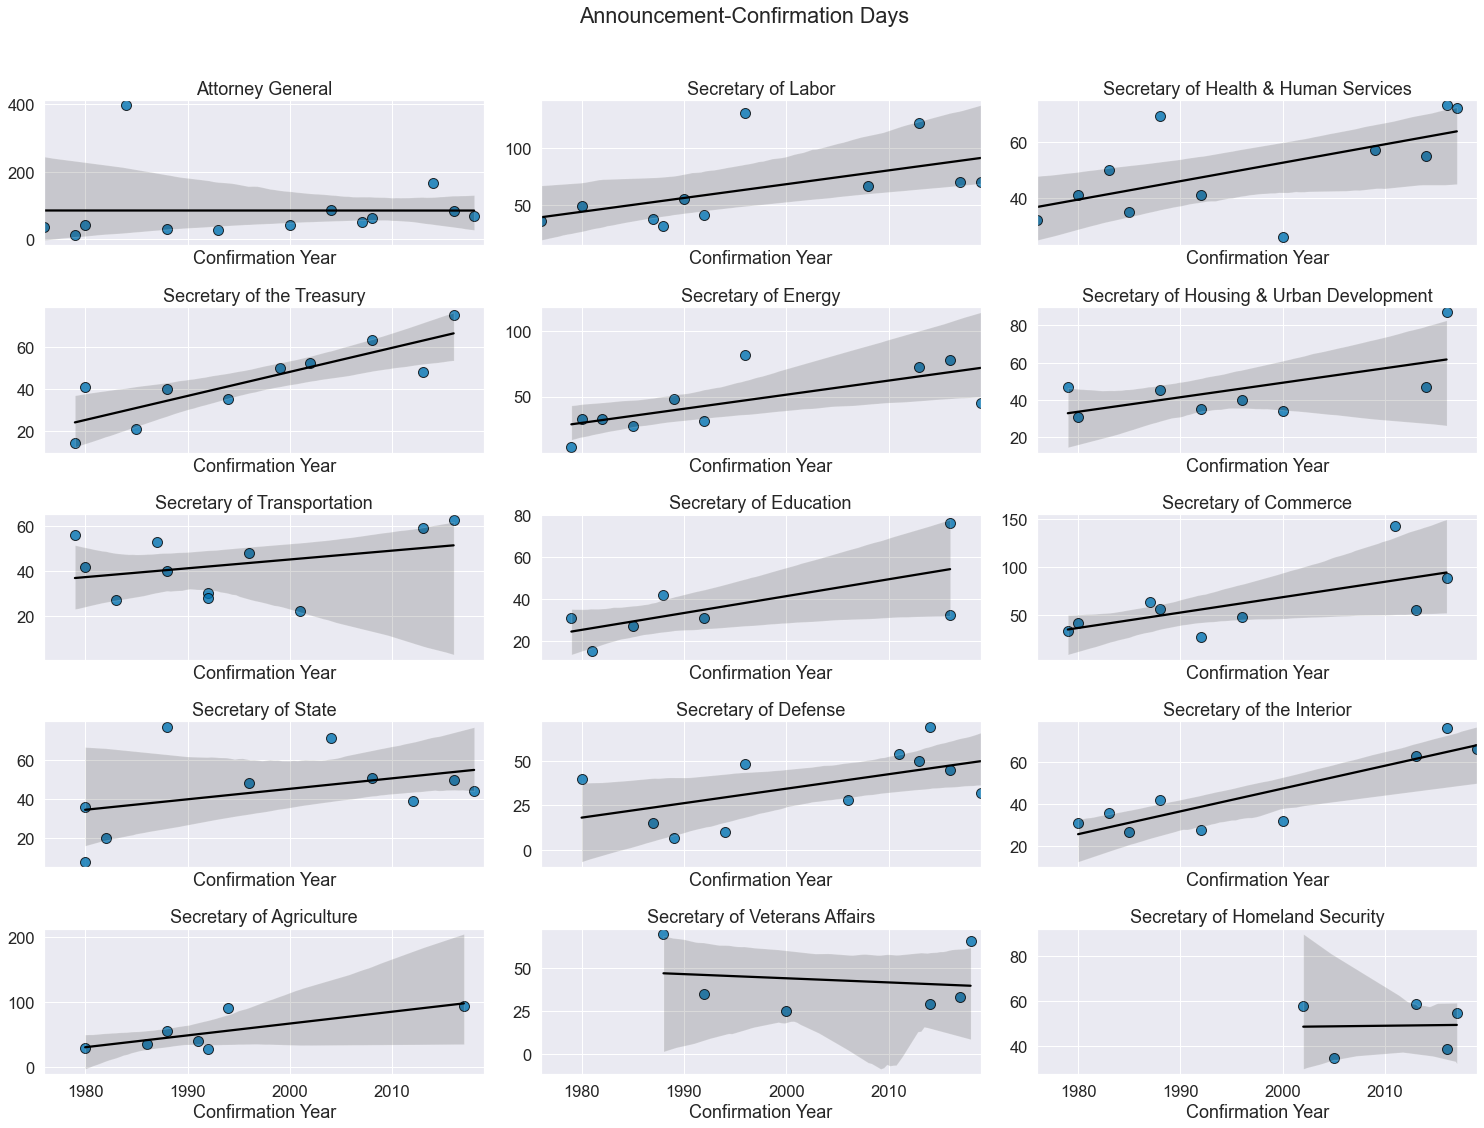

In [17]:
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (10.5 * 2, 7.5 * 2), sharex = True, sharey = False)

axes = axes.flatten()

for i, position_i in enumerate(nominee_announced_confirmed["position"].unique().tolist()):
    # regression plot
    sns.regplot(x = "announced_year", y = "announced_confirmed_days", data = nominee_announced_confirmed.query("position == '{}'".format(position_i)), scatter_kws = {"s": 100, "edgecolor": "black"}, lowess = False, line_kws = {"color": "black"}, ax = axes[i])
    
    axes[i].margins(0.04)
    
    # titles
    axes[i].set(xlabel = "Confirmation Year", ylabel = None, title = position_i)

# big title
fig.suptitle("Announcement-Confirmation Days", y = 1.05)

# tighten
fig.tight_layout()

# Models

## Center confirmation year around minimum year for the position

In [18]:
nominee_announced_confirmed["announced_year_min_c"] = nominee_announced_confirmed.groupby("position")["announced_year"].transform(lambda x: x - x.min())

## Predictor matrix

In [19]:
y, X = patsy.dmatrices("announced_confirmed_days ~ announced_year_min_c * C(position, Sum) + first_pick", data = nominee_announced_confirmed)

## Ridge, Lasso, Elastic Net regression grid search

In [20]:
# estimators
ridge = linear_model.Ridge(fit_intercept = True, max_iter = 1000)
lasso = linear_model.Lasso(fit_intercept = True, max_iter = 1000)
elastic_net = linear_model.ElasticNet(fit_intercept = True, max_iter = 1000)

# alpha parameters
param_grid1 = {"alpha": (10 ** np.linspace(start = 10, stop = -2, num = 10)) / 2}

# grid search
grid_search1 = model_selection.GridSearchCV(estimator = ridge, param_grid = param_grid1, cv = 5, scoring = "neg_mean_squared_error", verbose = 3)
grid_search2 = model_selection.GridSearchCV(estimator = lasso, param_grid = param_grid1, cv = 5, scoring = "neg_mean_squared_error", verbose = 3)
grid_search3 = model_selection.GridSearchCV(estimator = elastic_net, param_grid = param_grid1, cv = 5, scoring = "neg_mean_squared_error", verbose = 3)

### Ridge

In [21]:
# random state
np.random.seed(7352)

# fit
grid_search1.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] alpha=5000000000.0 ..............................................
[CV] ............... alpha=5000000000.0, score=-663.009, total=   0.0s
[CV] alpha=5000000000.0 ..............................................
[CV] .............. alpha=5000000000.0, score=-4628.690, total=   0.0s
[CV] alpha=5000000000.0 ..............................................
[CV] ............... alpha=5000000000.0, score=-721.861, total=   0.0s
[CV] alpha=5000000000.0 ..............................................
[CV] .............. alpha=5000000000.0, score=-1238.878, total=   0.0s
[CV] alpha=5000000000.0 ..............................................
[CV] ............... alpha=5000000000.0, score=-538.065, total=   0.0s
[CV] alpha=232079441.68063864 ........................................
[CV] ......... alpha=232079441.68063864, score=-662.965, total=   0.0s
[CV] alpha=232079441.68063864 ........................................
[CV] ........ al

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV] ...................... alpha=0.005, score=-741.270, total=   0.0s


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([5.00000000e+09, 2.32079442e+08, 1.07721735e+07, 5.00000000e+05,
       2.32079442e+04, 1.07721735e+03, 5.00000000e+01, 2.32079442e+00,
       1.07721735e-01, 5.00000000e-03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

### Lasso

In [22]:
# random state
np.random.seed(7352)

# fit
grid_search2.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] alpha=5000000000.0 ..............................................
[CV] ............... alpha=5000000000.0, score=-663.012, total=   0.0s
[CV] alpha=5000000000.0 ..............................................
[CV] .............. alpha=5000000000.0, score=-4628.690, total=   0.0s
[CV] alpha=5000000000.0 ..............................................
[CV] ............... alpha=5000000000.0, score=-721.861, total=   0.0s
[CV] alpha=5000000000.0 ..............................................
[CV] .............. alpha=5000000000.0, score=-1238.880, total=   0.0s
[CV] alpha=5000000000.0 ..............................................
[CV] ............... alpha=5000000000.0, score=-538.068, total=   0.0s
[CV] alpha=232079441.68063864 ........................................
[CV] ......... alpha=232079441.68063864, score=-663.012, total=   0.0s
[CV] alpha=232079441.68063864 ........................................
[CV] ........ al

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ..................... alpha=0.005, score=-5003.578, total=   0.0s
[CV] alpha=0.005 .....................................................
[CV] ...................... alpha=0.005, score=-868.439, total=   0.0s
[CV] alpha=0.005 .....................................................
[CV] ...................... alpha=0.005, score=-722.374, total=   0.0s
[CV] alpha=0.005 .....................................................
[CV] ...................... alpha=0.005, score=-737.500, total=   0.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([5.00000000e+09, 2.32079442e+08, 1.07721735e+07, 5.00000000e+05,
       2.32079442e+04, 1.07721735e+03, 5.00000000e+01, 2.32079442e+00,
       1.07721735e-01, 5.00000000e-03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

### Elastic Net

In [23]:
# random state
np.random.seed(7352)

# fit
grid_search3.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] alpha=5000000000.0 ..............................................
[CV] ............... alpha=5000000000.0, score=-663.012, total=   0.0s
[CV] alpha=5000000000.0 ..............................................
[CV] .............. alpha=5000000000.0, score=-4628.690, total=   0.0s
[CV] alpha=5000000000.0 ..............................................
[CV] ............... alpha=5000000000.0, score=-721.861, total=   0.0s
[CV] alpha=5000000000.0 ..............................................
[CV] .............. alpha=5000000000.0, score=-1238.880, total=   0.0s
[CV] alpha=5000000000.0 ..............................................
[CV] ............... alpha=5000000000.0, score=-538.068, total=   0.0s
[CV] alpha=232079441.68063864 ........................................
[CV] ......... alpha=232079441.68063864, score=-663.012, total=   0.0s
[CV] alpha=232079441.68063864 ........................................
[CV] ........ al

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([5.00000000e+09, 2.32079442e+08, 1.07721735e+07, 5.00000000e+05,
       2.32079442e+04, 1.07721735e+03, 5.00000000e+01, 2.32079442e+00,
       1.07721735e-01, 5.00000000e-03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

## Best parameters

In [24]:
grid_search1.best_params_, grid_search2.best_params_, grid_search3.best_params_

({'alpha': 1077.2173450159432},
 {'alpha': 2.320794416806396},
 {'alpha': 2.320794416806396})

## Best CV RMSE

In [25]:
np.sqrt(grid_search1.best_score_ * -1), np.sqrt(grid_search2.best_score_ * -1), np.sqrt(grid_search3.best_score_ * -1)

(36.87019487181124, 37.16347904865173, 37.15064555223613)

## Add predictions to data frame

In [26]:
nominee_announced_confirmed["announced_confirmed_days_predicted"] = grid_search1.predict(X)

## RMSE per position

In [47]:
nominee_announced_confirmed["error"] = nominee_announced_confirmed["announced_confirmed_days"] - nominee_announced_confirmed["announced_confirmed_days_predicted"]

nominee_announced_confirmed["squared_error"] = nominee_announced_confirmed["error"] ** 2

nominee_announced_confirmed.groupby("position")["squared_error"].mean().apply(np.sqrt).sort_values()

position
Secretary of the Interior                    11.077892
Secretary of the Treasury                    11.944238
Secretary of Homeland Security               12.197803
Secretary of Health & Human Services         12.474177
Secretary of Transportation                  12.885289
Secretary of Housing & Urban Development     13.421440
Secretary of Education                       16.270160
Secretary of Energy                          17.387621
Secretary of State                           18.256963
Secretary of Defense                         18.414414
Secretary of Agriculture                     18.561239
Secretary of Veterans Affairs                18.984502
Secretary of Commerce                        25.289730
Secretary of Labor                           26.981859
Attorney General                            100.900577
Name: squared_error, dtype: float64

## Mean error per position

In [28]:
nominee_announced_confirmed.groupby("position")["error"].describe().sort_values("mean")

,count,mean,std,min,25%,50%,75%,max
position,,,,,,,,
Secretary of Education,7.0,-7.652023,15.508881,-22.993510,-17.558050,-12.027659,-2.707818,21.988743
Secretary of Defense,11.0,-6.340061,18.132394,-32.362908,-19.662364,-0.700584,5.918216,23.638905
Secretary of the Interior,9.0,-4.674928,10.652362,-19.026440,-13.713634,-3.319878,1.592508,13.823509
Secretary of the Treasury,10.0,-4.210866,11.781974,-22.642858,-11.457504,-1.234623,2.912660,14.021969
Secretary of Energy,10.0,-3.628498,17.924638,-26.234618,-15.898772,-5.723444,7.724340,31.513801
Secretary of Housing & Urban Development,8.0,-2.060583,14.178013,-16.559344,-10.993637,-7.445692,4.030119,26.195541
Secretary of State,10.0,-1.832848,19.147305,-29.251287,-13.455810,-2.952157,2.201389,35.959641
Secretary of Transportation,11.0,-1.197039,13.455763,-25.148325,-12.632315,2.991448,7.625116,18.743922
Secretary of Health & Human Services,11.0,-0.360940,13.077549,-26.756582,-6.780806,-1.759073,8.103052,24.059585


## Mean absolute error per position

In [45]:
nominee_announced_confirmed.groupby("position")["error"].apply(lambda x: np.abs(x).mean()).sort_values()

position
Secretary of the Interior                    8.717104
Secretary of the Treasury                    9.299205
Secretary of Health & Human Services         9.698743
Secretary of Homeland Security              10.708203
Secretary of Transportation                 10.926050
Secretary of Housing & Urban Development    11.577342
Secretary of State                          14.022033
Secretary of Education                      14.123828
Secretary of Energy                         14.818657
Secretary of Defense                        15.025666
Secretary of Agriculture                    15.402313
Secretary of Veterans Affairs               16.853506
Secretary of Commerce                       17.754262
Secretary of Labor                          19.156489
Attorney General                            49.272215
Name: error, dtype: float64

In [68]:
(nominee_announced_confirmed.groupby("position").agg(mean_error = ("error", np.mean))
 .join(nominee_announced_confirmed.groupby("position").agg(root_mean_squared_error = ("error", lambda x: np.abs(x).mean())))
 .join(nominee_announced_confirmed.groupby("position").agg(mean_absolute_error = ("error", lambda x: np.mean(np.abs(x)))))
 .sort_values("root_mean_squared_error")
 .reset_index()
)

,position,mean_error,root_mean_squared_error,mean_absolute_error
0,Secretary of the Interior,-4.674928,8.717104,8.717104
1,Secretary of the Treasury,-4.210866,9.299205,9.299205
2,Secretary of Health & Human Services,-0.360940,9.698743,9.698743
3,Secretary of Homeland Security,5.115693,10.708203,10.708203
4,Secretary of Transportation,-1.197039,10.926050,10.926050
5,Secretary of Housing & Urban Development,-2.060583,11.577342,11.577342
6,Secretary of State,-1.832848,14.022033,14.022033
7,Secretary of Education,-7.652023,14.123828,14.123828
8,Secretary of Energy,-3.628498,14.818657,14.818657
9,Secretary of Defense,-6.340061,15.025666,15.025666


## Best estimator $R^2$

In [30]:
metrics.r2_score(y_true = y, y_pred = grid_search1.best_estimator_.predict(X)), metrics.r2_score(y_true = y, y_pred = grid_search2.best_estimator_.predict(X)), metrics.r2_score(y_true = y, y_pred = grid_search3.best_estimator_.predict(X))

(0.16437250550397942, 0.16485171091135653, 0.1666748298461289)

## Compare to OLS

In [41]:
sm.OLS.from_formula("announced_confirmed_days ~ announced_year_min_c * C(position, Sum) + first_pick", data = nominee_announced_confirmed).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     announced_confirmed_days   R-squared:                       0.234
Model:                                  OLS   Adj. R-squared:                  0.019
Method:                       Least Squares   F-statistic:                     1.089
Date:                      Sun, 24 Jan 2021   Prob (F-statistic):              0.364
Time:                              15:13:07   Log-Likelihood:                -681.20
No. Observations:                       138   AIC:                             1424.
Df Residuals:                           107   BIC:                             1515.
Df Model:                                30                                         
Covariance Type:                  nonrobust                                         
=====================================================================================================================================================
                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                            36.8470      5.584      6.599      0.000      25.778      47.916
C(position, Sum)[S.Attorney General]                                                 47.7686     18.620      2.565      0.012      10.856      84.681
C(position, Sum)[S.Secretary of Agriculture]                                         -5.9527     21.356     -0.279      0.781     -48.289      36.384
C(position, Sum)[S.Secretary of Commerce]                                            -1.4991     19.815     -0.076      0.940     -40.780      37.782
C(position, Sum)[S.Secretary of Defense]                                            -19.9609     22.246     -0.897      0.372     -64.061      24.139
C(position, Sum)[S.Secretary of Education]                                          -11.6801     20.041     -0.583      0.561     -51.410      28.049
C(position, Sum)[S.Secretary of Energy]                                              -8.6402     17.681     -0.489      0.626     -43.691      26.411
C(position, Sum)[S.Secretary of Health & Human Services]                              1.4551     19.245      0.076      0.940     -36.695      39.605
C(position, Sum)[S.Secretary of Homeland Security]                                   12.2117     28.333      0.431      0.667     -43.955      68.378
C(position, Sum)[S.Secretary of Housing & Urban Development]                         -3.1830     21.149     -0.151      0.881     -45.109      38.743
C(position, Sum)[S.Secretary of Labor]                                                4.4683     19.929      0.224      0.823     -35.039      43.975
C(position, Sum)[S.Secretary of State]                                               -2.8216     19.161     -0.147      0.883     -40.806      35.163
C(position, Sum)[S.Secretary of Transportation]                                      -0.7954     17.874     -0.045      0.965     -36.228      34.637
C(position, Sum)[S.Secretary of Veterans Affairs]                                    13.7214     25.828      0.531      0.596     -37.480      64.923
C(position, Sum)[S.Secretary of the Interior]                                       -10.1129     19.476     -0.519      0.605     -48.722      28.496
announced_year_min_c                                                                  0.7525      0.309      2.438      0.016       0.141       1.364
announced_year_min_c:C(position, Sum)[S.Attorney General]                            -0.7733      0.753     -1.027      0.307      -2.265       0.719
announced_year_mi

## Plot errors per position

/Users/nicholasmichalak/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/nicholasmichalak/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/nicholasmichalak/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNu

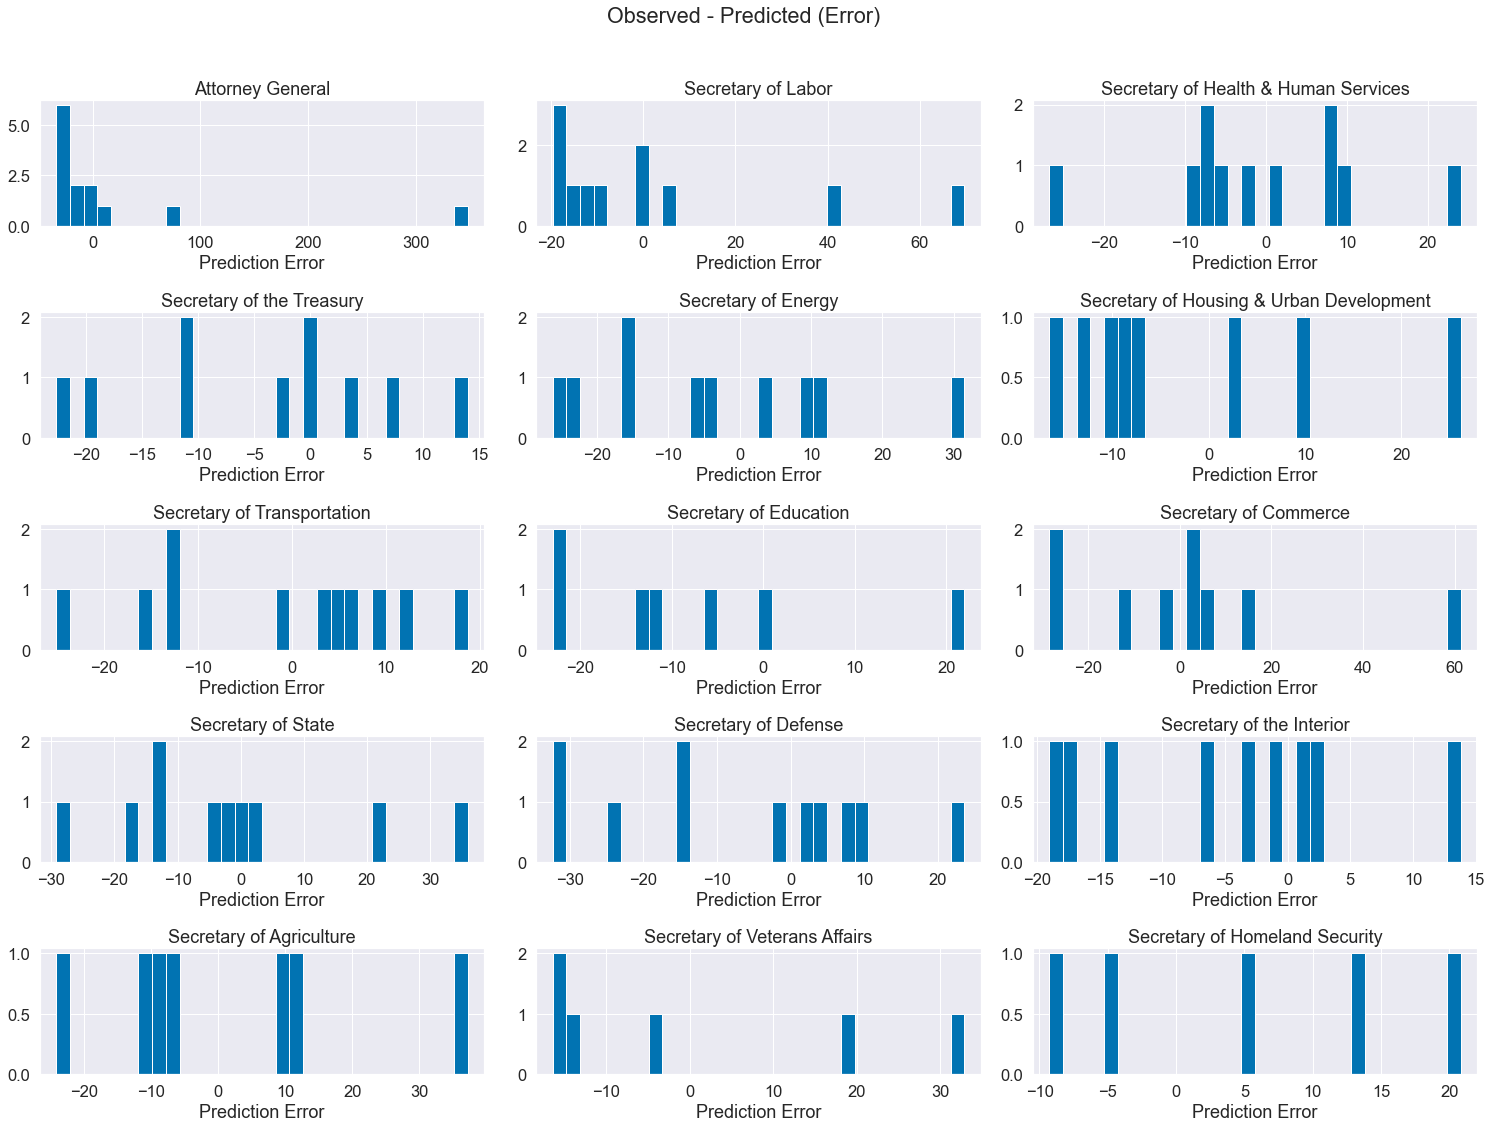

In [31]:
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (10.5 * 2, 7.5 * 2), sharex = False, sharey = False)

axes = axes.flatten()

for i, position_i in enumerate(nominee_announced_confirmed["position"].unique().tolist()):
    # histogram
    nominee_announced_confirmed.query("position == '{}'".format(position_i))["error"].plot(kind = "hist", bins = 30, ax = axes[i])
    
    axes[i].margins(0.04)
    
    # titles
    axes[i].set(xlabel = "Prediction Error", ylabel = None, title = position_i)

# big title
fig.suptitle("Observed - Predicted (Error)", y = 1.05)

# tighten
fig.tight_layout()

# Make predictions for Biden cabinet members

## Center confirmation year around minimum year for the position

In [32]:
biden_cabinet_nominations = biden_cabinet_nominations.merge(nominee_announced_confirmed.groupby("position")["announced_year"].min().reset_index(name = "position_year1"), how = "left", on = "position")

biden_cabinet_nominations["announced_year_min_c"] = biden_cabinet_nominations["announced_year"] - biden_cabinet_nominations["position_year1"]

# also first pick variable
biden_cabinet_nominations["first_pick"] = 0.5

# see it
biden_cabinet_nominations

,position,president,nominee,announced_date,announced_datetime,announced_year,position_year1,announced_year_min_c,first_pick
0,Secretary of Homeland Security,Joseph R. Biden,Alejandro Mayorkas,2020-11-23,2020-11-23,2020,2002,18,0.5
1,Secretary of State,Joseph R. Biden,Antony Blinken,2020-11-24,2020-11-24,2020,1980,40,0.5
2,Secretary of the Interior,Joseph R. Biden,Deb Haaland,2020-12-17,2020-12-17,2020,1980,40,0.5
3,Secretary of Veterans Affairs,Joseph R. Biden,Denis McDonough,2020-12-10,2020-12-10,2020,1988,32,0.5
4,Secretary of Defense,Joseph R. Biden,Gen. Lloyd Austin,2020-12-07,2020-12-07,2020,1980,40,0.5
5,Secretary of Commerce,Joseph R. Biden,Gina Raimondo,2021-01-07,2021-01-07,2021,1979,42,0.5
6,Secretary of the Treasury,Joseph R. Biden,Janet Yellen,2020-11-30,2020-11-30,2020,1979,41,0.5
7,Secretary of Energy,Joseph R. Biden,Jennifer Granholm,2020-12-17,2020-12-17,2020,1979,41,0.5
8,Secretary of Housing & Urban Development,Joseph R. Biden,Marcia Fudge,2020-12-10,2020-12-10,2020,1979,41,0.5
9,Secretary of Labor,Joseph R. Biden,Marty Walsh,2021-01-07,2021-01-07,2021,1976,45,0.5


## Predictor matrix

In [33]:
X_biden = patsy.dmatrix("announced_year_min_c * C(position, Sum) + first_pick", data = biden_cabinet_nominations)

## Add predictions to Biden data frame

In [36]:
# days
biden_cabinet_nominations["announced_confirmed_days_predicted"] = grid_search1.predict(X_biden)

# add days to annoncement date
biden_cabinet_nominations["confirmed_datetime_predicted"] = biden_cabinet_nominations["announced_datetime"] + biden_cabinet_nominations["announced_confirmed_days_predicted"].apply(lambda x: pd.DateOffset(n = int(round(x))))

# see it
biden_cabinet_nominations.sort_values("confirmed_datetime_predicted")

/Users/nicholasmichalak/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimelike.py:1215: PerformanceWarning: Adding/subtracting array of DateOffsets to DatetimeArray not vectorized
  PerformanceWarning,


,position,president,nominee,announced_date,announced_datetime,announced_year,position_year1,announced_year_min_c,first_pick,announced_confirmed_days_predicted,confirmed_datetime_predicted
0,Secretary of Homeland Security,Joseph R. Biden,Alejandro Mayorkas,2020-11-23,2020-11-23,2020,2002,18,0.5,51.485554,2021-01-13
1,Secretary of State,Joseph R. Biden,Antony Blinken,2020-11-24,2020-11-24,2020,1980,40,0.5,56.758112,2021-01-20
4,Secretary of Defense,Joseph R. Biden,Gen. Lloyd Austin,2020-12-07,2020-12-07,2020,1980,40,0.5,46.660294,2021-01-23
3,Secretary of Veterans Affairs,Joseph R. Biden,Denis McDonough,2020-12-10,2020-12-10,2020,1988,32,0.5,47.167344,2021-01-26
6,Secretary of the Treasury,Joseph R. Biden,Janet Yellen,2020-11-30,2020-11-30,2020,1979,41,0.5,63.624035,2021-02-02
12,Secretary of Transportation,Joseph R. Biden,Pete Buttigieg,2020-12-15,2020-12-15,2020,1979,41,0.5,55.812854,2021-02-09
8,Secretary of Housing & Urban Development,Joseph R. Biden,Marcia Fudge,2020-12-10,2020-12-10,2020,1979,41,0.5,63.365737,2021-02-11
14,Secretary of Health & Human Services,Joseph R. Biden,Xavier Becerra,2020-12-07,2020-12-07,2020,1976,44,0.5,65.783525,2021-02-11
11,Secretary of Education,Joseph R. Biden,Miguel Cardona,2020-12-23,2020-12-23,2020,1979,41,0.5,55.841856,2021-02-17
2,Secretary of the Interior,Joseph R. Biden,Deb Haaland,2020-12-17,2020-12-17,2020,1980,40,0.5,64.964003,2021-02-20


## Export predictions

In [35]:
biden_cabinet_nominations.loc[:, ["position", "nominee", "announced_datetime", "announced_year", "announced_confirmed_days_predicted", "confirmed_datetime_predicted"]].sort_values("announced_datetime").to_csv("202101_biden_cabinet_confirmation_predictions.csv", index = False)